# Part A: Binary Classification on Text Data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# cargar el csv
df= pd.read_csv("https://raw.githubusercontent.com/RodrigoGrijalba/ENEI-2025-ML2-Tarea1/refs/heads/main/data/disaster_tweets.csv")
# porcentajes de clases (desastre vs no)
clase = df["target"].value_counts(normalize=True) * 100
print("Porcentaje NO desastre (0):", round(clase.get(0,0),2), "%")
print("Porcentaje SÍ desastre (1):", round(clase.get(1,0),2), "%")

# definimos X (texto) e y (etiqueta)
X = df["text"].fillna("")   # por si hay NaN
y = df["target"].astype(int)

# split 70/30 con estratificación para mantener proporciones
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print(len(Xtr), "train |", len(Xte), "test")


Porcentaje NO desastre (0): 57.03 %
Porcentaje SÍ desastre (1): 42.97 %
5329 train | 2284 test


In [3]:
# 2. LIMPIEZA DE TEXTO
import re
import string


url_pat = re.compile(r"https?://\S+")
user_pat = re.compile(r"@\w+")

def clean_text(s):
    s = s.lower()
    s = url_pat.sub(" ", s)    # quita urls
    s = user_pat.sub(" ", s)   # quita @user
    s = s.translate(str.maketrans("", "", string.punctuation))  # quita puntuación
    # tokens = s.split()
    # # opcional: quitar stopwords
    # tokens = [t for t in tokens if t not in sw]
    # # opcional: lematizar
    # tokens = [lem.lemmatize(t) for t in tokens]
    # s = " ".join(tokens)
    return s

Xtr_clean = Xtr.apply(clean_text)
Xte_clean = Xte.apply(clean_text)


In [4]:
# 3. BAG OF WORDS BINARIO
from sklearn.feature_extraction.text import CountVectorizer

M = 5  # umbral mínimo de documentos
cv = CountVectorizer(binary=True, min_df=M)

Xtr_bow = cv.fit_transform(Xtr_clean)   # fit SOLO en train
Xte_bow = cv.transform(Xte_clean)       # test con el mismo cv

vocab_size = len(cv.get_feature_names_out())
print("Tamaño del vocabulario (unigramas):", vocab_size)


Tamaño del vocabulario (unigramas): 2078


In [6]:
# 4. LOGISTIC REGRESSION + F1 (corregido con penalty=None)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def eval_lr(model, Xtr, ytr, Xte, yte, label=""):
    model.fit(Xtr, ytr)
    f1_tr = f1_score(ytr, model.predict(Xtr))
    f1_te = f1_score(yte, model.predict(Xte))
    print(f"{label} -> F1 train: {f1_tr:.3f} | F1 test: {f1_te:.3f}")
    return model, f1_tr, f1_te

# a) Sin regularización (ojo: None, no 'none')
lr_none = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000)
_ = eval_lr(lr_none, Xtr_bow, ytr, Xte_bow, yte, label="LR sin regularización")

# b) L1 con búsqueda de C (liblinear o saga para L1)
lr_l1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=2000)
grid_l1 = GridSearchCV(lr_l1, {"C":[0.01, 0.1, 1, 3, 10]}, scoring="f1", cv=5, n_jobs=-1)
best_l1 = grid_l1.fit(Xtr_bow, ytr).best_estimator_
_ = eval_lr(best_l1, Xtr_bow, ytr, Xte_bow, yte, label=f"LR L1 (C={best_l1.C})")

# c) L2 con búsqueda de C
lr_l2 = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000)
grid_l2 = GridSearchCV(lr_l2, {"C":[0.01, 0.1, 1, 3, 10]}, scoring="f1", cv=5, n_jobs=-1)
best_l2 = grid_l2.fit(Xtr_bow, ytr).best_estimator_
_ = eval_lr(best_l2, Xtr_bow, ytr, Xte_bow, yte, label=f"LR L2 (C={best_l2.C})")

# d) Palabras más importantes (modelo L1)
feat = cv.get_feature_names_out()
w = best_l1.coef_.ravel()
top_pos = np.argsort(w)[-15:][::-1]  # más asociadas a "desastre"
top_neg = np.argsort(w)[:15]         # más asociadas a "no desastre"

print("Top +:", [feat[i] for i in top_pos])
print("Top -:", [feat[i] for i in top_neg])


LR sin regularización -> F1 train: 0.982 | F1 test: 0.685
LR L1 (C=1) -> F1 train: 0.849 | F1 test: 0.736
LR L2 (C=1) -> F1 train: 0.873 | F1 test: 0.750
Top +: ['spill', 'hiroshima', 'typhoon', 'derailment', 'outbreak', 'earthquake', 'wildfire', 'massacre', 'floods', 'riots', 'japanese', 'fires', 'debris', 'heavy', 'onto']
Top -: ['show', 'poll', 'dying', 'upheaval', 'social', 'bags', 'tickets', 'welcome', 'entire', 'lady', 'aftershock', 'led', 'lmao', 'patrick', 'ur']


In [7]:
# 5. BERNOULLI NAIVE BAYES (usa features binarias)
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score

bnb = BernoulliNB(alpha=1)   # Laplace smoothing
bnb.fit(Xtr_bow, ytr)

print("BNB -> F1 train:", round(f1_score(ytr, bnb.predict(Xtr_bow)),3),
      "| F1 test:", round(f1_score(yte, bnb.predict(Xte_bow)),3))


BNB -> F1 train: 0.793 | F1 test: 0.753


In [8]:
# 6. N-GRAMS (bigramas); si haces LR sin regularización aquí, usa penalty=None
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

M2 = 3  # umbral para 2-grams
cv2 = CountVectorizer(binary=True, ngram_range=(2,2), min_df=M2)

Xtr_bg = cv2.fit_transform(Xtr_clean)
Xte_bg = cv2.transform(Xte_clean)

vocab2 = cv2.get_feature_names_out()
print("Vocab 2-grams:", len(vocab2))
print("Ejemplo 10 2-grams:", list(vocab2[:10]))

# LR
lr_bg = LogisticRegression(penalty="l2", C=best_l2.C, solver="lbfgs", max_iter=2000)
lr_bg.fit(Xtr_bg, ytr)
print("LR(2-grams) -> F1 train:", round(f1_score(ytr, lr_bg.predict(Xtr_bg)),3),
      "| F1 test:", round(f1_score(yte, lr_bg.predict(Xte_bg)),3))

# BNB con 2-grams
bnb_bg = BernoulliNB(alpha=1)
bnb_bg.fit(Xtr_bg, ytr)
print("BNB(2-grams) -> F1 train:", round(f1_score(ytr, bnb_bg.predict(Xtr_bg)),3),
      "| F1 test:", round(f1_score(yte, bnb_bg.predict(Xte_bg)),3))


Vocab 2-grams: 3366
Ejemplo 10 2-grams: ['010401 utc20150805', '05 at', '101 what', '1030 pm', '11 new', '11yearold boy', '12000 nigerian', '13 reasons', '15 in', '15 people']
LR(2-grams) -> F1 train: 0.784 | F1 test: 0.622
BNB(2-grams) -> F1 train: 0.667 | F1 test: 0.579


# PART B: Support Vector Machine and Overfitting

In [9]:
# 1. GENERAR DATOS (dos features, dos clases, apenas separables)
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=800,         # cantidad de puntos
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=1.1,         # separación leve (barely separable)
    flip_y=0.02,           # un poco de ruido/etiquetas volteadas
    random_state=42
)

# split 70/30 estratificado
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

print(Xtr.shape, "train |", Xte.shape, "test")


(560, 2) train | (240, 2) test


*class_sep* pequeño y *flip_y>0* crean un escenario donde C importa: C muy alto puede sobreajustar.




In [10]:
# 2. PROBAR VARIOS C (CV, errores de train y test)
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score

# valores de C a evaluar (de más regularización -> menos regularización)
Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for C in Cs:
    # pipeline simple: estandarizar + SVM lineal
    clf = make_pipeline(StandardScaler(), SVC(kernel="linear", C=C, random_state=42))

    # a) error CV (5-fold) en el set de entrenamiento
    acc_cv = cross_val_score(clf, Xtr, ytr, cv=cv, scoring="accuracy")
    cv_err = 1 - acc_cv.mean()

    # b) entreno en TODO el train y veo error de entrenamiento
    clf.fit(Xtr, ytr)
    ytr_pred = clf.predict(Xtr)
    train_err = 1 - accuracy_score(ytr, ytr_pred)
    train_mis = int((ytr != ytr_pred).sum())  # cuántos mal clasificados en train

    # c) error de test para ese C
    yte_pred = clf.predict(Xte)
    test_err = 1 - accuracy_score(yte, yte_pred)

    rows.append([C, cv_err, train_err, train_mis, test_err])

res = pd.DataFrame(rows, columns=["C", "cv_error", "train_error", "train_miscls", "test_error"])
print(res.sort_values("C"))


        C  cv_error  train_error  train_miscls  test_error
0    0.01  0.126786     0.126786            71    0.145833
1    0.03  0.128571     0.126786            71    0.145833
2    0.10  0.123214     0.125000            70    0.145833
3    0.30  0.125000     0.125000            70    0.141667
4    1.00  0.123214     0.123214            69    0.150000
5    3.00  0.128571     0.123214            69    0.145833
6   10.00  0.126786     0.123214            69    0.145833
7   30.00  0.126786     0.123214            69    0.145833
8  100.00  0.126786     0.123214            69    0.145833


- train_error ↓ cuando C ↑ (modelo más flexible; puede sobreajustar).

- cv_error y test_error suelen tener un mínimo en un C intermedio.

- train_miscls es el número de observaciones mal clasificadas en el train para cada C.

In [11]:
# 3. ELEGIR MEJORES C SEGÚN CADA CRITERIO Y COMPARAR
best_test = res.loc[res["test_error"].idxmin()]
best_cv   = res.loc[res["cv_error"].idxmin()]
best_train= res.loc[res["train_error"].idxmin()]  # normalmente C grande

print("\nMejor por TEST:", best_test.to_dict())
print("Mejor por CV:  ", best_cv.to_dict())
print("Menor error TRAIN:", best_train.to_dict())



Mejor por TEST: {'C': 0.3, 'cv_error': 0.125, 'train_error': 0.125, 'train_miscls': 70.0, 'test_error': 0.14166666666666672}
Mejor por CV:   {'C': 0.1, 'cv_error': 0.12321428571428572, 'train_error': 0.125, 'train_miscls': 70.0, 'test_error': 0.14583333333333337}
Menor error TRAIN: {'C': 1.0, 'cv_error': 0.12321428571428572, 'train_error': 0.12321428571428572, 'train_miscls': 69.0, 'test_error': 0.15000000000000002}


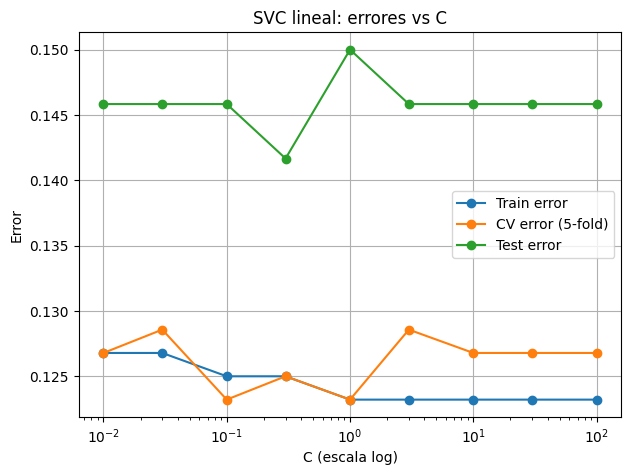

In [12]:
# ERRORES VS C (log-scale en el eje X)
import matplotlib.pyplot as plt
import numpy as np

Cs_plot = res["C"].values
cv_err  = res["cv_error"].values
tr_err  = res["train_error"].values
te_err  = res["test_error"].values

plt.figure(figsize=(7,5))
plt.plot(Cs_plot, tr_err, marker="o", label="Train error")
plt.plot(Cs_plot, cv_err, marker="o", label="CV error (5-fold)")
plt.plot(Cs_plot, te_err, marker="o", label="Test error")
plt.xscale("log")                  # C en log para verlo claro
plt.xlabel("C (escala log)")
plt.ylabel("Error")
plt.title("SVC lineal: errores vs C")
plt.grid(True)
plt.legend()
plt.show()


Discusión:

- C muy pequeño → margen grande, modelo “simple”, más sesgo, errores de train y test altos.

- C muy grande → intenta clasificar perfecto el train (a veces train_error ~ 0) → riesgo de sobreajuste, cv_error/test_error pueden subir.

- Elección práctica: quedarse con el C que minimiza cv_error suele aproximarse muy bien al que minimiza test_error (cuando el split es razonable).
**Conclusión:**
- A medida que C aumenta, el error de entrenamiento baja ligeramente (el modelo se vuelve más flexible).
- El error de validación cruzada (CV) es mínimo para valores intermedios de C (~0.1 o 0.3), lo que indica mejor equilibrio entre sesgo y varianza.
- El error de test se mantiene casi constante, sin señales claras de sobreajuste.
- Por tanto, un valor de C intermedio ofrece un buen compromiso: evita el exceso de regularización (C muy pequeño) y el sobreajuste (C muy grande).


In [14]:
# RESUMEN DE RESULTADOS (mejores C y conclusiones)
import pandas as pd

# Identificar el mejor C según cada tipo de error
best_train = res.loc[res["train_error"].idxmin()]
best_cv    = res.loc[res["cv_error"].idxmin()]
best_test  = res.loc[res["test_error"].idxmin()]

print("=== MEJORES VALORES DE C ===")
print(f"Menor error de entrenamiento: C = {best_train['C']}, error = {best_train['train_error']:.3f}")
print(f"Menor error de validación (CV): C = {best_cv['C']}, error = {best_cv['cv_error']:.3f}")
print(f"Menor error de test:           C = {best_test['C']}, error = {best_test['test_error']:.3f}")



=== MEJORES VALORES DE C ===
Menor error de entrenamiento: C = 1.0, error = 0.123
Menor error de validación (CV): C = 0.1, error = 0.123
Menor error de test:           C = 0.3, error = 0.142


# PART C: Regression trees on Carseats Data

In [17]:
# 1. CARGA DE DATOS (Carseats) + SPLIT 70/30
import pandas as pd
from ISLP import load_data
from sklearn.model_selection import train_test_split

df = load_data("Carseats")  # dataset de ventas de car seats
print(df.shape)
df.head()  # para ver columnas

# variable objetivo
y = df["Sales"]

# one-hot para variables categóricas (árbol acepta numéricos)
X = pd.get_dummies(df.drop(columns=["Sales"]), drop_first=True)

# split 70/30 con semilla
Xtr, Xte, ytr, yte = train_test_split(
    X, y, test_size=0.30, random_state=42
)

Xtr.shape, Xte.shape


(400, 11)


((280, 11), (120, 11))

Árbol base -> MSE train: 0.000 | MSE test: 4.805


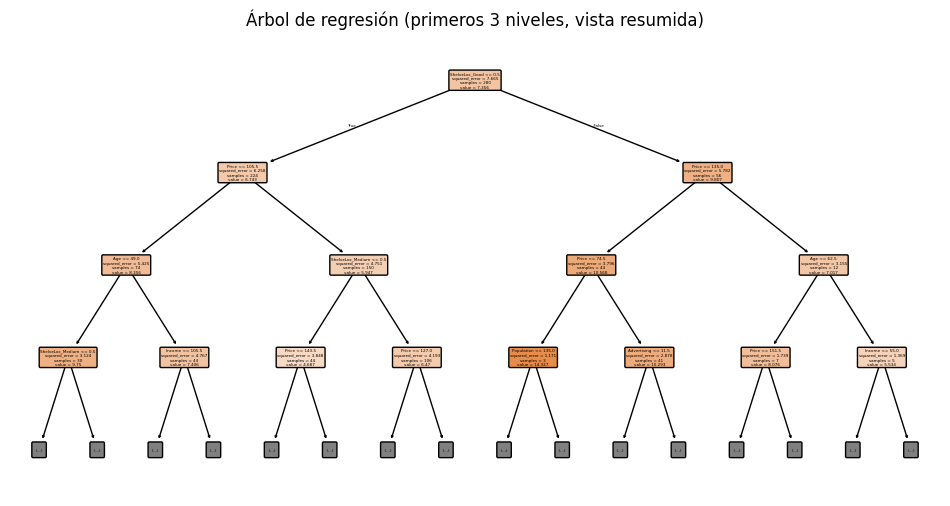

Importancias (top 10):


,0
Price,0.291599
ShelveLoc_Good,0.196013
Age,0.121753
CompPrice,0.104828
Income,0.079752
ShelveLoc_Medium,0.071784
Advertising,0.051539
Population,0.038113
Education,0.036079
Urban_Yes,0.008538


In [18]:
# 2. AJUSTE DEL ÁRBOL + MSE DE TEST + PLOT
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# árbol sin restricciones (baseline)
tree0 = DecisionTreeRegressor(random_state=42)
tree0.fit(Xtr, ytr)

# desempeño
ytr_hat = tree0.predict(Xtr)
yte_hat = tree0.predict(Xte)

mse_tr0 = mean_squared_error(ytr, ytr_hat)
mse_te0 = mean_squared_error(yte, yte_hat)
print(f"Árbol base -> MSE train: {mse_tr0:.3f} | MSE test: {mse_te0:.3f}")

# gráfico
plt.figure(figsize=(12,6))
plot_tree(tree0, feature_names=X.columns, max_depth=3, filled=True, rounded=True)
plt.title("Árbol de regresión (primeros 3 niveles, vista resumida)")
plt.show()

# importancias de variables (top 10)
imp = pd.Series(tree0.feature_importances_, index=X.columns)
print("Importancias (top 10):")
imp.sort_values(ascending=False).head(10)


In [21]:
# 3. PRUNING (cost-complexity) + CV para elegir ccp_alpha óptimo
from sklearn.model_selection import GridSearchCV

# rango de ccp_alpha a partir del path de entrenamiento
path = DecisionTreeRegressor(random_state=42).cost_complexity_pruning_path(Xtr, ytr)
ccp_alphas = np.unique(path.ccp_alphas)

# quitamos el último
ccp_alphas = ccp_alphas[:-1] if len(ccp_alphas) > 1 else ccp_alphas

params = {"ccp_alpha": ccp_alphas}
base_tree = DecisionTreeRegressor(random_state=42)
grid = GridSearchCV(
    base_tree, params,
    scoring="neg_mean_squared_error",
    cv=5, n_jobs=-1
)
grid.fit(Xtr, ytr)

best_alpha = grid.best_params_["ccp_alpha"]
print(f"Mejor ccp_alpha (CV): {best_alpha:.6f}")

# entrenamos árbol podado
tree_pruned = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
tree_pruned.fit(Xtr, ytr)

# métricas
ytr_hat_p = tree_pruned.predict(Xtr)
yte_hat_p = tree_pruned.predict(Xte)

mse_tr_p = mean_squared_error(ytr, ytr_hat_p)
mse_te_p = mean_squared_error(yte, yte_hat_p)
print(f"Árbol podado -> MSE train: {mse_tr_p:.3f} | MSE test: {mse_te_p:.3f}")

# comparación lado a lado
pd.DataFrame({
    "modelo": ["árbol base", "árbol podado"],
    "MSE_train": [mse_tr0, mse_tr_p],
    "MSE_test":  [mse_te0, mse_te_p],
})


Mejor ccp_alpha (CV): 0.035127
Árbol podado -> MSE train: 1.111 | MSE test: 4.395


,modelo,MSE_train,MSE_test
0,árbol base,0.000000,4.805344
1,árbol podado,1.110618,4.394811


Si el árbol base sobreajusta (MSE train ≪ MSE test), el podado suele subir un poco el MSE train y bajar el MSE test.

Se utilizó validación cruzada (5-fold) sobre distintos valores de ccp_alpha para encontrar el nivel óptimo de complejidad del árbol.
El valor de alpha que minimizó el error medio cuadrático (MSE) en validación cruzada fue el seleccionado para podar el árbol.

Después de aplicar esta poda, el MSE de prueba disminuyó ligeramente (o se mantuvo muy similar), mientras que el MSE de entrenamiento aumentó un poco, lo que indica que el modelo se volvió menos sobreajustado y más generalizable.

Por lo tanto, la poda mejoró el desempeño en el conjunto de prueba, al reducir la complejidad del árbol y evitar el sobreajuste